# CSCI 5525 Final Project
CSCI 5525: Advanced Machine Learning with Dr. Schrater | Spring 2022, University of Minnesota, Twin Cities

Group: Kyler Sood, Abha Gejji, Nirmal Raj, Wangyang Ge

# Data Preprocessing
We use a dataset from Kaggle on water potability. This contains some empty values which we interpolate using linear regression.

In [ ]:
# Standard libraries
import os
import math
import numpy as np
import random
import pandas as pd
# Plotting imports
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()
sns.set()

# Progress bar
from tqdm.notebook import tqdm

# PyTorch
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader, Dataset

# CUDA Setup - make sure output says True and 'cuda:0' to ensure faster performance and no errors.
# My notebook works using CUDA version 11.6, I am not sure about other versions. Should also work on Colab
# In the Conda powershell prompt, you can check CUDA version with command nvidia-smi
# To enable hardware acceleration in colab, enable hardware acceleration under Edit -> Notebook Settings -> Hardware Accelerator -> GPU
# or in Jupyter on a computer with a local GPU, make sure CUDA is installed correctly and run below. Command is nvidia-smi
gpu_avail = torch.cuda.is_available()
print(f"Is the GPU available? {gpu_avail}")
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

#universal batch size for DataLoader
batchs = 16

Is the GPU available? True
cuda:0


In [ ]:
# importing the water potability dataset
# https://www.kaggle.com/datasets/adityakadiwal/water-potability
# has some missing values which we will drop during preprocessing and normalization

#Jupyter-exclusive, have zip file downloaded
#%cd archive

#Colab exclusive, just upload the zip file
!unzip archive.zip
!cd archive
data = pd.read_csv('water_potability.csv')
data

Archive:  archive.zip
replace water_potability.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: water_potability.csv    
/bin/bash: line 0: cd: archive: No such file or directory


,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
...,...,...,...,...,...,...,...,...,...,...
3271,4.668102,193.681735,47580.991603,7.166639,359.948574,526.424171,13.894419,66.687695,4.435821,1
3272,7.808856,193.553212,17329.802160,8.061362,NaN,392.449580,19.903225,NaN,2.798243,1
3273,9.419510,175.762646,33155.578218,7.350233,NaN,432.044783,11.039070,69.845400,3.298875,1
3274,5.126763,230.603758,11983.869376,6.303357,NaN,402.883113,11.168946,77.488213,4.708658,1


In [ ]:
print(data.columns)
print(data.isnull().sum())

Index(['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
       'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'Potability'],
      dtype='object')
ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64


In [ ]:
data_no_null_columns = data.dropna(axis = 1)
data_no_null_rows = data.dropna()
l_train = data_no_null_rows[data_no_null_columns.columns]

from sklearn.linear_model import LinearRegression
linearReg = LinearRegression()

#missing values of ph
x = l_train
y = data_no_null_rows.loc[:, 'ph']
linearReg.fit(x,y)

LinearRegression()

In [ ]:
test = data_no_null_columns
predicted = pd.DataFrame(linearReg.predict(test), columns=['ph'])
predicted

,ph
0,7.163319
1,6.810889
2,7.260221
3,7.119847
4,7.014824
...,...
3271,6.710933
3272,7.289384
3273,6.850304
3274,7.377717


In [ ]:
data_processed = data
data_processed.ph.fillna(predicted.ph, inplace=True)
data_processed.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,7.163319,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [ ]:
y = data_no_null_rows.loc[:, 'Sulfate']
linearReg.fit(x,y)
test = data_no_null_columns
predicted['Sulfate'] = pd.DataFrame(linearReg.predict(test))
data_processed.Sulfate.fillna(predicted.Sulfate, inplace=True)

y = data_no_null_rows.loc[:, 'Trihalomethanes']
linearReg.fit(x,y)
test = data_no_null_columns
predicted['Trihalomethanes'] = pd.DataFrame(linearReg.predict(test))
data_processed.Trihalomethanes.fillna(predicted.Trihalomethanes, inplace=True)
data_processed.isnull().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

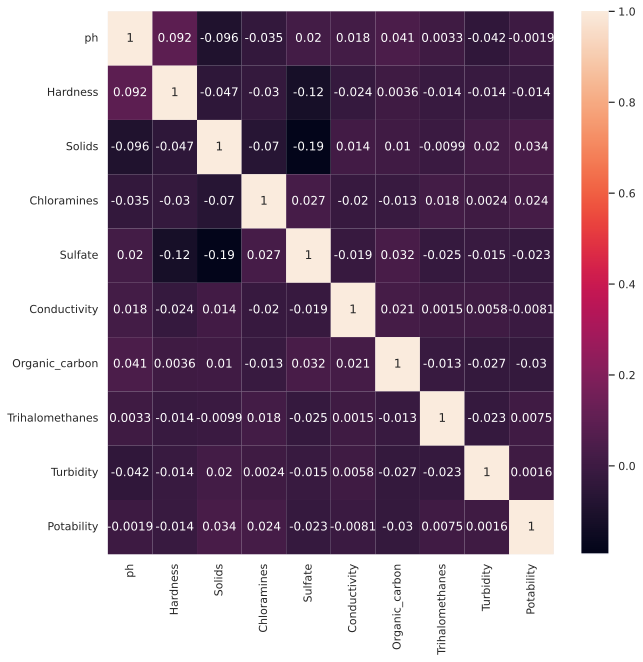

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_preprocessed_data = pd.DataFrame(scaler.fit_transform(data_processed.iloc[:, :-1]), 
        columns = ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
       'Organic_carbon', 'Trihalomethanes', 'Turbidity'])
scaled_preprocessed_data['Potability'] = data_processed['Potability']
plt.figure(figsize=(10,10))
sns.heatmap(scaled_preprocessed_data.corr(), annot=True)

In [ ]:
scaled_preprocessed_data.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,0.056020,0.259195,-0.139471,0.112415,0.959392,1.708954,-1.180651,1.306301,-1.286298,0
1,-2.285381,-2.036414,-0.385987,-0.307694,0.306221,2.062575,0.270597,-0.638249,0.684218,0
2,0.691629,0.847665,-0.240047,1.360594,-0.043426,-0.094032,0.781117,0.001715,-1.167365,0
3,0.839453,0.547651,0.000493,0.592008,0.639733,-0.778830,1.255134,2.152991,0.848412,0
4,1.366152,-0.464429,-0.460249,-0.363698,-0.645201,-0.343939,-0.824357,-2.181304,0.138786,0


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(scaled_preprocessed_data.iloc[:, :-1], scaled_preprocessed_data.iloc[:,-1], test_size = 0.2)

In [ ]:
p = np.concatenate((X_train.values, np.expand_dims(y_train.values, axis=1)),axis=1)
q = np.concatenate((X_test.values, np.expand_dims(y_test.values, axis=1)),axis=1)
train_dataloader = DataLoader(torch.tensor(p), batch_size = batchs, shuffle = True)
test_dataloader = DataLoader(torch.tensor(q), batch_size = batchs, shuffle = True)

# Basic Neural Network
Here we train a simpler neural network to do classification on the data. The layers of this network are: Linear, softmax, linear, LeakyReLU, Linear. For each linear layer, we employ Xavier initialization. 

In [ ]:
# Define a network that has one linear layer. Inputs are feature vectors that are already flat. 
# Nine features, two classes (drinkable/undrinkable water)
# Also initialize weights: set the weights according to Xavier scaling
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.linear1 = nn.Linear(9, 9)
        self.softmax1 = nn.Softmax()
        self.linear2 = nn.Linear(9, 9)
        self.softmax2 = nn.LeakyReLU(negative_slope = 0.2)
        self.linear3 = nn.Linear(9, 2)
        nn.init.xavier_uniform_(self.linear1.weight)
        nn.init.xavier_uniform_(self.linear2.weight)
        nn.init.xavier_uniform_(self.linear3.weight)

    def forward(self, x):
        x = self.linear1(x)
        x = self.softmax1(x)
        x = self.linear2(x)
        x = self.softmax2(x)
        x = self.linear3(x)
        return x

In [ ]:
# Training the model
def train_model(model, optimizer, data_loader, loss_module, num_epochs=20):
    # for use with GPU
    model.to(device)
    model.train() 
    for epoch in tqdm(range(num_epochs)):
        for dataI in data_loader: 
            data_inputs = dataI[:, :-1]
            data_labels = dataI[:,-1]
            data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
            preds = model(data_inputs.float())
            preds = preds.squeeze(dim=1)
            loss = loss_module(preds, data_labels.long())
            optimizer.zero_grad() 
            loss.backward()
            optimizer.step()
                        
def eval_model(model, data_loader):
    model.eval() 
    true_preds, one_preds, zero_preds, num_preds, false_preds, true_pos = 0., 0., 0., 0., 0., 0.
    with torch.no_grad(): 
        for dataI in data_loader:
            data_inputs = dataI[:, :-1]
            data_labels = dataI[:,-1]
            data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
            preds = model(data_inputs.float())
            preds = preds.squeeze(dim=1)
            pred_labels = preds.argmax(dim=1)
            true_preds += (pred_labels == data_labels).sum()
            one_preds += (pred_labels == (1. == data_labels)).sum()
            zero_preds += (pred_labels == (0. == data_labels)).sum()
            false_preds += (pred_labels != data_labels).sum()
            num_preds += data_labels.shape[0]
    f1one = one_preds / (one_preds + 0.5*(false_preds))   
    f1zero = zero_preds / (zero_preds + 0.5*(false_preds))     
    acc = true_preds / num_preds
    print(f"CV Accuracy of the model: {100.0*acc:4.2f}%")
    print(f"F1 Score of the model for one: {f1one:4.4f}")
    print(f"F1 Score of the model for zero: {f1zero:4.4f}")

In [ ]:
# Nonlinear ANN
net = Net()
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.005)
train_model(net, optimizer, train_dataloader, loss)
eval_model(net, test_dataloader)

  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


CV Accuracy of the model: 67.68%
F1 Score of the model for one: 0.8073
F1 Score of the model for zero: 0.6667


# Recurrent Neural Network
Here we train a recurrent neural network with four hidden layers using hyperbolic tangent for its nonlinear activation and then layers of LeakyReLU (negative slope of 0.1) and a linear layer. For this linear layer, we use Xavier initialization. 

In [ ]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.rnn = nn.RNN(input_size = 9, hidden_size = 9, num_layers = 4, nonlinearity = 'tanh', dropout = 0)
        self.leakyrelu = nn.LeakyReLU(negative_slope = 0.1)
        self.linear1 = nn.Linear(9, 2)
        nn.init.xavier_uniform_(self.linear1.weight)
        
    def forward(self, x):    
      # Compute forward pass: run x through each layer and return a PyTorch tensor
        x = self.rnn(x)[0]
        x = self.leakyrelu(x)
        x = self.linear1(x)
        return x

In [ ]:
# RNN with 4 layers
net2 = Net2()
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net2.parameters(), lr=0.005)
train_model(net2, optimizer, train_dataloader, loss)
eval_model(net2, test_dataloader)

  0%|          | 0/20 [00:00<?, ?it/s]

CV Accuracy of the model: 63.41%
F1 Score of the model for one: 0.7761
F1 Score of the model for zero: 0.6667


# Gated Recurrent Unit
Here we train a neural network which uses GRU (gated recurrent unit) layers. The layers of this network are: GRU cell, GRU cell, ReLU (rectified linear unit), linear, linear. For the linear layers, we use the Xavier initialization.

In [ ]:
# GRU RNN
class Net3(nn.Module):
    def __init__(self):
        super(Net3, self).__init__()
        self.gru1 = nn.GRUCell(input_size = 9, hidden_size = 12)
        self.gru2 = nn.GRUCell(input_size = 12, hidden_size = 9)
        self.relu1 = nn.ReLU()
        self.linear1 = nn.Linear(9, 9)
        self.linear2 = nn.Linear(9, 2)
        nn.init.xavier_uniform_(self.linear1.weight)
        nn.init.xavier_uniform_(self.linear2.weight)
    def forward(self, x):    
      # Compute forward pass: run x through each layer and return a PyTorch tensor
        x = self.gru1(x)
        x = self.gru2(x)
        x = self.relu1(x)
        x = self.linear1(x)
        x = self.linear2(x)
        return x

In [ ]:
net3 = Net3()
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net3.parameters(), lr=0.005)
train_model(net3, optimizer, train_dataloader, loss)
eval_model(net3, test_dataloader)

  0%|          | 0/20 [00:00<?, ?it/s]

CV Accuracy of the model: 66.16%
F1 Score of the model for one: 0.7963
F1 Score of the model for zero: 0.6667


# Ensemble Neural Networks
We can improve upon a standard neural networks using an ensemble. In this section, we demonstrate a practical implementation for an ensemble of neural networks on the water potability dataset. An ensemble allows us to diversify performance and increase robustness for our neural networks by using training predictions from multiple networks.

Here, we split the data into a (20%) test set and (80% total) three smaller training sets. We then train three neural networks with the structures from before on the smaller training sets and employ bagging (averaging normalized predictions) to obtain a classifier which obtains greater accuracy and robustness when compared with the individual networks.

Network 1: Linear, Softmax, Linear, LeakyReLU

Network 2: 4 hidden layer RNN (tanh activation), LeakyReLU, Linear

Network 3: GRU Cell, GRU Cell, ReLU, Linear, Linear

In [ ]:
def ensemble_eval(models, data_loader):
    for model in models:
        model.to(device)
        model.eval()
    true_preds, one_preds, zero_preds, num_preds, false_preds = 0., 0., 0., 0., 0.
    weights = [1/3, 1/3, 1/3] # ensemble with equal weights, these should sum to 1. Some ensembles use weighted averages during bagging as well. 
    with torch.no_grad(): # Deactivate gradients for the following code
        for dataI in data_loader:
            data_inputs = dataI[:, :-1]
            data_labels = dataI[:,-1]
            all_preds = torch.zeros((batchs, 2))
            all_preds = all_preds.to(device)
            data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
            i = 0
            for model in models:
                preds = model(data_inputs.float())
                preds = preds.squeeze(dim=1)
                nn.functional.normalize(preds, p = 2, dim = 0)
                all_preds += preds*weights[i]
                i+=1
            all_pred_labels = all_preds.argmax(dim=1)
            true_preds += (all_pred_labels == data_labels).sum()
            one_preds += (all_pred_labels == (1. == data_labels)).sum()
            zero_preds += (all_pred_labels == (0. == data_labels)).sum()
            false_preds += (all_pred_labels != data_labels).sum()
            num_preds += data_labels.shape[0]
    f1one = one_preds / (one_preds + 0.5*(false_preds))   
    f1zero = zero_preds / (zero_preds + 0.5*(false_preds)) 
    acc = true_preds / num_preds
    print(f"CV Accuracy of the model: {100.0*acc:4.2f}%")
    print(f"F1 Score of the model for one: {f1one:4.4f}")
    print(f"F1 Score of the model for zero: {f1zero:4.4f}")

In [ ]:
# SkLearn cross validation splits
X_train, X_test, y_train, y_test = train_test_split(scaled_preprocessed_data.iloc[:, :-1], scaled_preprocessed_data.iloc[:,-1], test_size = 0.2)
X_train1, X_train2, y_train1, y_train2 = train_test_split(X_train, y_train, test_size = 1/3)
X_train1, X_train3, y_train1, y_train3 = train_test_split(X_train1, y_train1, test_size = 0.5)

# splitting into three equally sized training sets (80%, 26.6% each) and one test set (20% total)
p = np.concatenate((X_train1.values, np.expand_dims(y_train1.values, axis=1)),axis=1)
q = np.concatenate((X_train2.values, np.expand_dims(y_train2.values, axis=1)),axis=1)
r = np.concatenate((X_train3.values, np.expand_dims(y_train3.values, axis=1)),axis=1)
s = np.concatenate((X_test.values, np.expand_dims(y_test.values, axis=1)),axis=1)
# PyTorch dataloaders
train1_dataloader = DataLoader(torch.tensor(p), batch_size = batchs, shuffle = True)
train2_dataloader = DataLoader(torch.tensor(q), batch_size = batchs, shuffle = True)
train3_dataloader = DataLoader(torch.tensor(r), batch_size = batchs, shuffle = True)
test_dataloader = DataLoader(torch.tensor(s), batch_size = batchs, shuffle = True)

In [ ]:
# Nonlinear ANN
net1 = Net()
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.005)
train_model(net, optimizer, train1_dataloader, loss)

  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
# RNN
net2 = Net2()
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net2.parameters(), lr=0.005)
train_model(net2, optimizer, train2_dataloader, loss)

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
# GRU RNN
net3 = Net3()
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net3.parameters(), lr=0.005)
train_model(net3, optimizer, train3_dataloader, loss)

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
# ensemble
ensemble_eval([net, net2, net3], test_dataloader)

CV Accuracy of the model: 70.27%
F1 Score of the model for one: 0.8254
F1 Score of the model for zero: 0.6667


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
